In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Disclaimer

The results obtained in this notebook are **poor** and disorganized.

The major reason is probably the high number of features but, depending on the fold, feature reduction methods did not yield much better results either. Different ways of decreasing the number of features have been implemented so far: Lasso, RandomForest, PCA and based on the variance of each feature. None of these lead to satisfying results. Feel free to look at the notebook but keep that in mind. Alternatives solutions have to be investigated and papers read. 

I also apologize for not having had the time to make some cleaning before traveling, it is still pretty messy. 

## GDSC dataset

Please note that before running the code, you will need all the GDSC files. They can be found on the drive (https://drive.google.com/drive/u/1/folders/11omvpOttkdZZgv_ppbtcCbojkuVR-D61) or directly on the GDSC website.

In [9]:
PATH = "data/GDSC/" #where your data is located

#### Cell populations and labels

File which represents how well each cell population reacted to each drug. 

1. How is the drug measured?

    a. **IC50:** describes the concentration of an inhibitor that results in a half-maximal inhibition of a response (i.e. the concentration that reduces a response to 50% of its maximum). That maximum response being inhibited is due to the action of something else (typically an agonist for the receptor of interest). Maximum IC50 = 8. Minimum IC50 = 0. 
    
    IC50 is obtained by plotting a measure of the cell death rate vs the concentration of the drug. IC50 is expressed as a concentration so the higher the concentration of drug needed to kill the cell line the more resistant that cell line is. If the IC50 is very low then the concentration (or amount) of drug needed to kill the cell line is also very low which means the cell line is more sensitive. Typically you get a S curve or sigmoidal curve. IC50 is the middle point of the sigmoidal curve. The threshold for calling a drug sensitive/resistant changes depending upon the IC50 value and we need to see how the sigmoidal curve behaves.
    
    d.	**ActArea:** "*Sensitivity was assayed by measuring cellular ATP levels as a surrogate  for cell number and growth. Raw data were merged with assay metadata, and percent-viability scores were calculated relative to DMSO controls, after which concentration-response curves were fit for percent viability. The areas under percent-viability curves were computed and used as the measure of sensitivity*". In one paper, the limit was set to **0.8 SD**. Sensitive cell lines were the ones with an activity area at least 0.8 SD above the mean. Resistant cell lines had an activity area at least 0.8 SD below the mean. All other samples were discared.
    


In [40]:
data = pd.read_csv(PATH + "Preliminary_matrix.csv", index_col = 'Unnamed: 0')
data.drop('RPMI8402_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', axis = 0, inplace = True)
data.head()

,SZT2_mut,TCHH_mut,HRNR_mut,FLG2_mut,BAZ2B_mut,SCN9A_mut,ANK2_mut,RP1L1_mut,ABCA2_mut,EP400_mut,...,SERPINB7_del,TNFRSF11A_del,SERPINB12_del,SERPINB11_del,CTDP1_del,DSEL_del,SOCS6_del,VPS4B_del,ZNF516_del,Response
22RV1_PROSTATE,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A673_BONE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CORL23_LUNG,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
# Looking at class balance

print("Number of resistant cells: ", len(data[data["Response"] == "resistant"]))
print("Number of sensitive cells: ", len(data[data["Response"] == "sensitive"]))
print("Total number of cells: ", len(data.index))

C:\Users\Asus\Anaconda3\envs\data-x\lib\site-packages\pandas\core\ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

We see that our classes are more or less equal (which is good!). 

In [26]:
data["Response"] = data["Response"].astype("category", categories=["sensitive","resistant"]).cat.codes
data.head()

C:\Users\Asus\Anaconda3\envs\data-x\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


,SZT2_mut,TCHH_mut,HRNR_mut,FLG2_mut,BAZ2B_mut,SCN9A_mut,ANK2_mut,RP1L1_mut,ABCA2_mut,EP400_mut,...,SERPINB7_del,TNFRSF11A_del,SERPINB12_del,SERPINB11_del,CTDP1_del,DSEL_del,SOCS6_del,VPS4B_del,ZNF516_del,Response
22RV1_PROSTATE,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A673_BONE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
CORL23_LUNG,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def example_model(ML_matrix):
    
    X = ML_matrix.drop("Response", axis = 1)
    y = ML_matrix["Response"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train.values.tolist(), y_train.values)

    #clf.feature_importances_

    print("Accuracy on the training set: ", clf.score(X_train.values.tolist(), y_train.values.tolist()))
    print("Accuracy on the test set: ", clf.score(X_test.values.tolist(), y_test.values.tolist()))
    
    return

example_model(data)

Accuracy on the training set:  1.0
Accuracy on the test set:  0.4057971014492754


By inputting this into a random forest, we get an accuracy on the training set of 1.0 (the bias on the model is very low, which is good). On the other hand, the accuracy on the test set is **0.49**. This means that the variance is huge and the model is overfitting like crazy (this is understandable considering the large number of features we have). In other words, our classifier is no better than picking randomly a label for each cell (= no predictive value what so ever). 

Number of features before PCA:  455
Number of combined features after PCA:  90


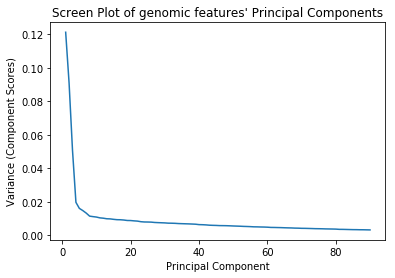

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89
0,-1.911703,5.219578,-1.259504,-0.548193,-1.472842,-0.268394,0.607039,-3.006861,-2.000720,-0.498824,...,0.223154,-0.104516,-0.203157,0.177741,-0.051791,0.146140,-0.013294,0.354631,-0.325462,0.036150
1,-0.844669,-1.896888,-0.120029,-0.357893,0.293527,1.044397,0.840361,0.464123,0.067707,0.412593,...,-0.010666,0.130971,0.618133,0.495525,-0.135062,-0.322213,-0.046702,-0.292168,-0.275141,-0.351241
2,-0.844080,-1.963400,0.827912,-0.354907,-0.130323,1.048017,1.116913,-0.272995,-0.439952,0.255352,...,0.030196,0.166602,-0.227216,0.126761,0.062688,0.588147,-0.109590,-0.031770,-0.083362,0.032205
3,-0.803024,-0.070102,3.614516,-1.616295,-0.129554,-1.310338,-1.046064,0.549364,0.547207,0.735096,...,-0.063434,-0.841408,1.394838,0.239264,-0.355907,0.602891,0.326067,-0.661967,-0.295668,0.527609
4,-1.546921,3.041960,-0.848400,-0.980797,0.658518,-0.443124,0.248369,-1.107382,-0.299723,0.414654,...,0.160463,-0.743184,-0.274468,-0.454756,0.191489,-0.275894,0.592011,0.183854,-0.581897,-0.790374


In [42]:
from sklearn.decomposition import PCA

NB_COMPONENTS = 90
screeplot = True

def make_pca(X, nb_components = 100, screeplot = False):
    
    print("Number of features before PCA: ", len(X.columns))

    my_PCA = PCA(n_components=nb_components)
    reduced_X = pd.DataFrame(my_PCA.fit_transform(np.array(X.values), y=None))
    reduced_X.columns = [f"PC{elem}" for elem in range(nb_components)]

    print("Number of combined features after PCA: ",len(list(reduced_X)))
    
    if screeplot:
        fig = plt.figure()
        g = sns.lineplot(x = range(1,nb_components+1), y = my_PCA.explained_variance_ratio_)
        plt.xlabel('Principal Component')
        plt.ylabel('Variance (Component Scores)')
        plt.title('Screen Plot of genomic features\' Principal Components')
        plt.show(); 

    return reduced_X

reduced_X = make_pca(data.drop("Response", axis = 1), nb_components = NB_COMPONENTS, screeplot = True)
reduced_X.head()

Let's try our random forest again.

In [43]:
def scale_data(X_train, X_test):
    
    feature_names = list(X_train) # Store the feature names
    
    sc = StandardScaler()  #defines the scaler
    X_train = pd.DataFrame(sc.fit_transform(X_train))  #scales the training data
    X_test = pd.DataFrame(sc.transform(X_test))  #scales the validation data

    #Replace feature names in the database (they are lost during scaling)
    X_train.columns = feature_names
    X_test.columns = feature_names
    
    return X_train, X_test

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif

#def initial_feature_reduction(X):
    

In [31]:
#variances = pd.DataFrame(ML_matrix.var(axis = 0))
#important_features = variances.sort_values(0, ascending = False).drop("Response").index[:100]

#important_X = X.loc[:,important_features].copy()
#important_X.loc[:,"Response"] = ML_matrix.loc[:,"Response"]
#display(important_X)

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE

def run_model(X, y, n_splits = 5):
    
    train_accuracies, val_accuracies, rocs = [],[],[]

    # Define a cross-validation (shuffleSplit here)
    ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for count, (training_indices, val_indices) in enumerate(ss.split(X, y), 1):

        print(f'Cross-validation: {count}/{n_splits}')

        # Prepare the test and training set     
        X_train = X.iloc[training_indices,:]#.sample(frac=1, random_state = 6)
        y_train = y.iloc[training_indices]#.sample(frac=1, random_state = 6)
        X_val = X.iloc[val_indices,:]#.sample(frac=1, random_state = 6)
        y_val = y.iloc[val_indices]#.sample(frac=1, random_state = 6)
        
        print(f"The validation set corresponds to roughly {np.round(100*(len(X_val.index)/len(X.index)),2)}% of the total data.") 
        
        #Scaling the features -- useful for most classifier except RF and co
        X_train, X_val = scale_data(X_train, X_val)
    
        #, mutual_info_classif, chi2
        
        #selector = SelectKBest(f_classif, k=150) 
        #X_train = pd.DataFrame(selector.fit_transform(X_train, y_train))
        #X_val =  pd.DataFrame(selector.transform(X_val))
        
        # Feature selection
        #X_train, X_val = lasso_feature_reduction(X_train, X_val, y_train, Cst = 0.01)
        
        selector = RFE(LinearSVC(max_iter = 10000), 80)
        X_train = pd.DataFrame(selector.fit_transform(X_train, y_train))
        X_val = pd.DataFrame(selector.transform(X_val))

        
        # Define the classifier
        #clf = RandomForestClassifier(n_estimators=500, max_depth = 5, n_jobs = -1, random_state=0)
        clf = LinearSVC(max_iter = 10000)
        #clf = MLPClassifier(alpha = 1e-5, random_state = 0, max_iter = 1000)
        
        # Fit the classifier
        clf.fit(X_train.values.tolist(), y_train.values)        
        
        # Predict the classes
        y_pred = clf.predict(X_val.values.tolist())
        
        # Calculate the performance metrics 
        train_acc = accuracy_score(y_train.values.tolist(), clf.predict(X_train.values.tolist()))
        val_acc = accuracy_score(y_val.values.tolist(), y_pred)
        #roc_auc = roc_auc_score(y_val.values, clf.predict_proba(X_val.values)[:, 1])
        
        print(f"Training accuracy {count}: {train_acc}")
        print(f"Validation accuracy {count}: {val_acc}")
        #print(f"ROC AUC {count}: {roc_auc}")
    
        # Add the performances to their corresponding lists
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        #rocs.append(roc_auc)
    print("_________________________________________________________________________________")   
    print(f'Average training accuracy {np.round(100*np.mean(train_accuracies), 2)} +/- {np.round(100*np.std(train_accuracies),2)}%.')
    print(f'Average validation accuracy {np.round(100*np.mean(val_accuracies),2)} +/- {np.round(100*np.std(val_accuracies),2)}%.')
    #print(f'Average area under the curve {np.round(100*np.mean(np.array(rocs)),2)} +/- {np.round(100*np.std(np.array(rocs)),2)}%.')
    
    return 100*np.mean(train_accuracies), 100*np.std(train_accuracies), 100*np.mean(val_accuracies), 100*np.std(val_accuracies), 100*np.mean(np.array(rocs)), 100*np.std(np.array(rocs))

N_SPLITS = 5

X = data.drop("Response", axis = 1)
y = data["Response"].astype('float64')

performances = run_model(reduced_X, y, n_splits = N_SPLITS)

Cross-validation: 1/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 1: 0.8695652173913043
Validation accuracy 1: 0.5217391304347826
Cross-validation: 2/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 2: 0.842391304347826
Validation accuracy 2: 0.5869565217391305
Cross-validation: 3/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 3: 0.9021739130434783
Validation accuracy 3: 0.41304347826086957
Cross-validation: 4/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 4: 0.8913043478260869
Validation accuracy 4: 0.5
Cross-validation: 5/5
The validation set corresponds to roughly 20.0% of the total data.
Training accuracy 5: 0.8695652173913043
Validation accuracy 5: 0.5
_________________________________________________________________________________
Average training accuracy 87.5 +/- 2.06%.
Average validation accuracy 50.43 +/- 5.57%.


C:\Users\Asus\Anaconda3\envs\data-x\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Asus\Anaconda3\envs\data-x\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Asus\Anaconda3\envs\data-x\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Asus\Anaconda3\envs\data-x\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Asus\Anaconda3\envs\data-x\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
def lasso_feature_reduction(X_train, X_val, y_train, Cst = 0.01):
    
    clf = LinearSVC(C = Cst, penalty = "l1", dual = False) #SVC(kernel = 'linear', C = Cst)
    clf.fit(X_train.values, y_train)
    
    model = SelectFromModel(clf, prefit=True)
    new_X_train = model.transform(X_train.values)
    new_X_val = model.transform(X_val.values)
    
    return pd.DataFrame(new_X_train), pd.DataFrame(new_X_val)

In [52]:
def rf_feature_reduction(X_train, X_val, y_train, N_ESTIMATORS = 500):
    
    clf = RandomForestClassifier(n_estimators = N_ESTIMATORS, n_jobs = -1, class_weight = "balanced", random_state = 32)
    clf = clf.fit(X_train.values, y_train.values)
    
    model = SelectFromModel(clf, prefit=True)   
    new_X_train = model.transform(X_train)
    new_X_val = model.transform(X_val)
    
    importances = clf.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0) --> std dev but we don't use it anyway
    
    return pd.DataFrame(new_X_train), pd.DataFrame(new_X_val), importances